In [100]:
import pymrio as pym
import numpy as np
import pandas as pd
import pickle as pkl
import pathlib
import country_converter as coco
import json

def display_f(df):
    with pd.option_context('display.max_colwidth', None), pd.option_context('display.max_rows', None), pd.option_context('display.max_columns', None):
        display(df)
        
def lexico_reindex(mrio: pym.IOSystem) -> pym.IOSystem:
    """Reindex IOSystem lexicographicaly

    Sort indexes and columns of the dataframe of a :ref:`pymrio.IOSystem` by
    lexical order.

    Parameters
    ----------
    mrio : pym.IOSystem
        The IOSystem to sort

    Returns
    -------
    pym.IOSystem
        The sorted IOSystem

    """

    mrio.Z = mrio.Z.reindex(sorted(mrio.Z.index), axis=0)
    mrio.Z = mrio.Z.reindex(sorted(mrio.Z.columns), axis=1)
    mrio.Y = mrio.Y.reindex(sorted(mrio.Y.index), axis=0)
    mrio.Y = mrio.Y.reindex(sorted(mrio.Y.columns), axis=1)
    mrio.x = mrio.x.reindex(sorted(mrio.x.index), axis=0) #type: ignore
    mrio.A = mrio.A.reindex(sorted(mrio.A.index), axis=0)
    mrio.A = mrio.A.reindex(sorted(mrio.A.columns), axis=1)

    return mrio

exio_path = "../../../Data/Snakeruns/inputs/IOT_2019_ixi.zip"
exio3 = pym.parse_exiobase3(path=exio_path)
del exio3.IOT_2019_ixi

original_regions = exio3.get_regions()

cc = coco.CountryConverter()

dico = {region : cc.convert(region, src="EXIO3",to='continent') for region in original_regions}
dico['WA'] = 'Oceania'
dico['WL'] = 'America'
dico['WE'] = 'Europe'
dico['WF'] = 'Africa'
dico['WM'] = 'Asia'

reg_agg_coco = coco.agg_conc(original_countries=original_regions, aggregates=dico)

exio3.aggregate(region_agg=reg_agg_coco)

attr = ['Z', 'Y', 'x', 'A', 'L', 'unit', 'population', 'meta', '__non_agg_attributes__', '__coefficients__', '__basic__']
tmp = list(exio3.__dict__.keys())
for at in tmp:
    if at not in attr:
        delattr(exio3,at)

old_sectors = exio3.get_sectors()

sec_agg_matrix = pd.read_excel("../other/133_7_sector_aggregation_exiobase3.ods", sheet_name="input", engine="odf", header=None, names=old_sectors)

exio3.aggregate(sector_agg=sec_agg_matrix.to_numpy())
with pathlib.Path("../other/sector_renaming_7.json").open('r') as f:
    a = json.load(f)
exio3.rename_sectors(a)
new_sectors = exio3.get_sectors()
sec_agg_matrix.index = new_sectors

sector_mapping = {k : [kk for kk in v.keys() if v[kk] == 1] for k,v in sec_agg_matrix.T.to_dict().items()}

In [ ]:
sector_mapping

In [116]:
with pathlib.Path("../../../Data/BoARIO-testing/163_mrio_params.json").open('r') as f:
    old_mrio_params = json.load(f)

new_mrio_params = old_mrio_params.copy()
new_mrio_params['capital_ratio_dict'] = {k:0 for k in sector_mapping.keys()}

for k in new_mrio_params['capital_ratio_dict'].keys():
    values = [old_mrio_params['capital_ratio_dict'][k_old] for k_old in sector_mapping[k]]
    new_mrio_params['capital_ratio_dict'][k] = np.mean(values).round(3)
    
new_mrio_params['inventories_dict'] = {k:0 for k in sector_mapping.keys()}

for k in new_mrio_params['inventories_dict'].keys():
    values = [np.inf if old_mrio_params['inventories_dict'][k_old] == "inf" else old_mrio_params['inventories_dict'][k_old] for k_old in sector_mapping[k]]
    new_mrio_params['inventories_dict'][k] = np.mean(values).round(3)
    
new_mrio_params['inventories_dict']

{'Agriculture & other': 9.0,
 'Extraction': 9.0,
 'Manufacture': 9.0,
 'Energy and utilities': 9.0,
 'Construction': 9.0,
 'Sales, Transports and Services': inf,
 'Others': inf}

In [112]:
list(old_sectors)

['Cultivation of paddy rice',
 'Cultivation of wheat',
 'Cultivation of cereal grains nec',
 'Cultivation of vegetables, fruit, nuts',
 'Cultivation of oil seeds',
 'Cultivation of sugar cane, sugar beet',
 'Cultivation of plant-based fibers',
 'Cultivation of crops nec',
 'Cattle farming',
 'Pigs farming',
 'Poultry farming',
 'Meat animals nec',
 'Animal products nec',
 'Raw milk',
 'Wool, silk-worm cocoons',
 'Manure treatment (conventional), storage and land application',
 'Manure treatment (biogas), storage and land application',
 'Forestry, logging and related service activities (02)',
 'Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)',
 'Mining of coal and lignite; extraction of peat (10)',
 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
 'Extraction of natural gas and services related to natural gas extraction, excluding surveying',
 'Extraction, liquefaction, and regasificat

In [61]:
exio3.calc_all()
exio3 = lexico_reindex(exio3)
with open("../../../Data/BoARIO-testing/minimal_mrio.pkl", 'wb') as f:
    pkl.dump(exio3, f)

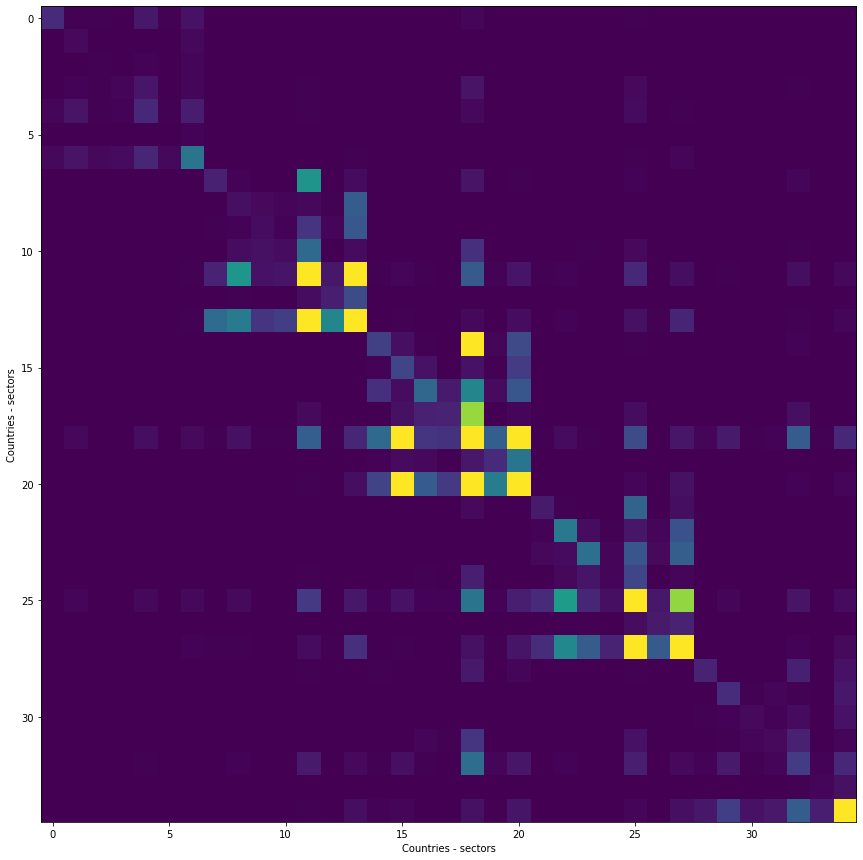

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(exio3.Z, vmax=1E6)
plt.xlabel('Countries - sectors')
plt.ylabel('Countries - sectors')
plt.show()

In [50]:
with open("../../../Data/BoARIO-testing/minimal_mrio.pkl", 'rb') as f:
    exio3 = pkl.load(f)

In [73]:
#### TEST SUBDIVISE SECTOR

mrio = exio3.copy()
def _split_sector_df_Z_shape(df_name:str, mrio_in: pym.IOSystem, sector: str, split_number: int = 2, internal_exchange: bool = False) -> pd.DataFrame:
    """Split a sector dataframe in two sub-sector 
    
    """
    if not hasattr(mrio_in, df_name):
        raise ValueError("DataFrame '{}' was not found in the MRIO".format(df_name))
    if sector not in mrio_in.get_sectors():
        raise ValueError("Sector '{}' was not found in the MRIO".format(sector))
    idx = pd.IndexSlice
    mrio = mrio_in.copy()
    df = getattr(mrio,df_name)
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    
    df = df.T
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    df = df.T
    if not internal_exchange:
        for i in range(split_number):
            df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(i+1)]] = df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(i+1)]] * split_number
            for j in range(split_number):
                if i!=j:
                    df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(j+1)]] = 0
    return df

def _split_sector_df_xY_shape(df_name:str, mrio_in: pym.IOSystem, sector: str, split_number: int = 2) -> pd.DataFrame:
    if not hasattr(mrio_in, df_name):
        raise ValueError("DataFrame '{}' was not found in the MRIO".format(df_name))
    if sector not in mrio_in.get_sectors():
        raise ValueError("Sector '{}' was not found in the MRIO".format(sector))
    idx = pd.IndexSlice
    mrio = mrio_in.copy()
    df = getattr(mrio,df_name)
    df = df.T
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    
    df = df.T
    return df

def split_sector(mrio_in: pym.IOSystem, sector: str, mrio_params: str, split_number: int = 2, internal_exchange: bool = False):
    mrio = mrio_in.copy()
    mrio.Z = _split_sector_df_Z_shape("Z", mrio_in, sector, split_number, internal_exchange)
    mrio.A = _split_sector_df_Z_shape("A", mrio_in, sector, split_number, internal_exchange)
    mrio.x = _split_sector_df_xY_shape("x", mrio_in, sector, split_number)
    mrio.Y = _split_sector_df_xY_shape("Y", mrio_in, sector, split_number)
    return mrio

In [67]:
exio3.get_sectors()

Index(['Agriculture & other', 'Construction', 'Energy and utilities',
       'Extraction', 'Manufacture', 'Others',
       'Sales, Transports and Services'],
      dtype='object', name='sector')

In [80]:
mrio = split_sector(exio3, 'Construction', split_number=2, internal_exchange=False)
with open("../../../Data/BoARIO-testing/minimal_mrio_2cons.pkl", 'wb') as f:
    pkl.dump(mrio, f)